In [18]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
vgg16 = models.vgg16(pretrained=True)

vgg16 = vgg16.features
vgg16.eval()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [20]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, categories, transform=None):
        self.root_dir = root_dir
        self.categories = categories
        self.transform = transform
        self.data = []

        for label, category in enumerate(categories):
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
catagories = ["black", "no_black"]

train_dataset = ImageDataset("augmented_data/train", catagories, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageDataset("augmented_data/val", catagories, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = ImageDataset("augmented_data/test", catagories, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [24]:
features = []
labels = []

with torch.no_grad():  
    for images, lbls in train_loader:
        images = images.to(device)
        
        feature_maps = vgg16(images)
        feature_vectors = torch.flatten(feature_maps, start_dim=1).cpu().numpy()

        features.extend(feature_vectors)
        labels.extend(lbls.numpy())

X_train = np.array(features)
y_train = np.array(labels)

In [25]:
features = []
labels = []

with torch.no_grad():  
    for images, lbls in val_loader:
        images = images.to(device)
        
        feature_maps = vgg16(images)
        feature_vectors = torch.flatten(feature_maps, start_dim=1).cpu().numpy()

        features.extend(feature_vectors)
        labels.extend(lbls.numpy())

X_val = np.array(features)
y_val = np.array(labels)

In [26]:
features = []
labels = []

with torch.no_grad():  
    for images, lbls in test_loader:
        images = images.to(device)
        
        feature_maps = vgg16(images)
        feature_vectors = torch.flatten(feature_maps, start_dim=1).cpu().numpy()

        features.extend(feature_vectors)
        labels.extend(lbls.numpy())

X_test = np.array(features)
y_test = np.array(labels)

In [27]:
model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
result = classification_report(y_test, y_pred, target_names=catagories)
print(result)

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

       black       0.93      0.93      0.93       150
    no_black       0.93      0.93      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



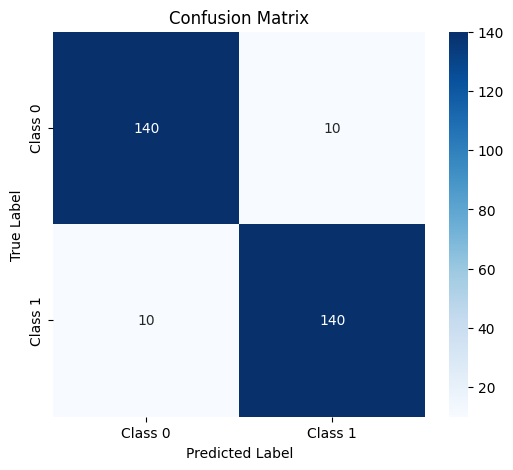

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
param_grid = {
    "C": [0.1, 0.5, 1, 2, 10],
    "gamma": ["scale", "auto", 0.1, 1, 5],
    "kernel": ["linear", "rbf"]
}

In [30]:
from sklearn.model_selection import GridSearchCV
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_val, y_val)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.99


In [31]:
model = SVC(C = 0.1, gamma = "scale", kernel = "linear")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
result = classification_report(y_test, y_pred, target_names=catagories)
print(result)

Accuracy: 0.9533333333333334
              precision    recall  f1-score   support

       black       0.95      0.95      0.95       150
    no_black       0.95      0.95      0.95       150

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



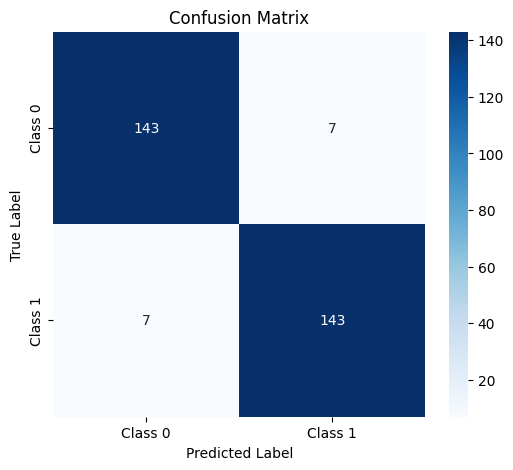

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()